In [1]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np

import scanpy as sc
from anndata import AnnData
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, rc_context

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})

In [31]:
def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata


def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df


def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df


def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df


def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    return data


def group_by_molecule(df, groupby_columns):
    '''
    Aggregate intensity and detection values per groupby columns
    '''          
    data = df.groupby(groupby_columns).agg({
        'detectability' : 'max', # here detectability of metabolite is set to 1 if any of it's ions was detected
        'property1' : 'sum', # here the additional property is summed across all detected ions of metabolite
        'property2' : 'sum', # here the additional property is summed across all detected ions of metabolite
        'property3' : 'sum' # here the additional property is summed across all detected ions of metabolite
    }).reset_index()
    return data


def summarise_per_class(df, groupby_columns):
    
    data = df.groupby(groupby_columns).agg({'detectability' : 'sum', # here number of detected metabolites per class is counted
                                            'my_property' : 'mean', # here you take a mean of some property among all detected metabolites in that class
                                            'class_size': 'first'
                                            }).reset_index()

    data['fraction_detected'] = data.detectability / data['class_size'] 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    return data


def assemble_adata(pca):
    observables = pca.index.to_frame(index=False)
    for col in observables.columns:
        observables[col] = observables[col].astype('category')  
    variables = pca.columns.to_frame(index=False)
    adata = AnnData(pca.values, obs=observables, var=variables)
    return adata

- Inputs

In [20]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"
p_out = p_root_dir / "6_plots" / "Interlab"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "2022-08-16_All_Interlab_Predictions.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_14Jul2022.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"

- Merge relevant info into one dataframe

In [32]:
# Load predictions
predictions = pd.read_csv(p_predictions, index_col=0)
print(predictions.columns)

Index(['dataset_id', 'name_short', 'formula', 'adduct', 'neutral_loss', 'well',
       'occupancy_ratio', 'on_off_ratio', 'spot_occupancy',
       'spot_occupancy_thresholded', 'image_occupancy',
       'other_spots_occupancy', 'bg_occupancy', 'far_bg_occupancy',
       'occupancy_vs_far_bg_ratio', 'in_n_spots', 'spot_intensity',
       'spot_intensity_bgr_corrected', 'spot_intensity_sum',
       'spot_intensity_std', 'other_spot_intensity', 'bg_intensity',
       'far_bg_intensity', 'intensity_vs_far_bg_ratio',
       'intensity_vs_other_spots_ratio', 'spot_intensity_tic_norm',
       'spot_intensity_bgr_corrected_tic_norm', 'spot_intensity_sum_tic_norm',
       'spot_intensity_std_tic_norm', 'other_spot_intensity_tic_norm',
       'bg_intensity_tic', 'far_bg_intensity_tic',
       'intensity_vs_far_bg_ratio_tic', 'intensity_vs_other_spots_ratio_tic',
       'score', 'pred_val', 'pred_twostate', 'pred_threestate'],
      dtype='object')


In [137]:
# Format neutral loss column, keep other columns that you need
predictions = pd.read_csv(p_predictions, index_col=0)


predictions.neutral_loss.fillna('', inplace=True)

# Add dataset metadata 
datasets = pd.read_csv(p_datasets)
metadata_columns = ['Dataset name', 
                    'Participant lab', 
                    'Technology', 
                    'Original technology', 
                    'Ionisation source',
                    'Mass analyser', 
                    'Source pressure',
                    'Matrix short',
                    'Polarity', 
                    'Slide code',
                    'Interlab', 
                    'All'
                   ]
datasets_info = datasets.groupby('Dataset ID').first()[metadata_columns]

# Merge with predictions
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

# Filter to keep only interlab datasets + EMBL datasets with 10ppm
df = df[df['Interlab']] 
# only consider data of detected ions
threshold = 0.8
df['detectability'] = df.pred_val >= threshold
data = df[df.detectability]

## Option 1: Build PCA based on the intenisities and detectability of all metabolites
- Each metabolite is an average of its detected ions

In [138]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
                            polarity='negative', 
                            neutral_losses=['']
                           )

# Add property that you want to use for PCA
filtered_data['property1'] = filtered_data['on_off_ratio'] * 1 # this is just an example that does nothing to the column, but you can do whatever
filtered_data['property2'] = filtered_data['spot_intensity_bgr_corrected_tic_norm'] * 1
filtered_data['property3'] = filtered_data['bg_intensity_tic'] * 1

# Summarise data per metabolite and dataset
molecule_data = group_by_molecule(filtered_data, groupby_columns=np.append(metadata_columns, 'name_short').tolist())

# Reshape
pca = molecule_data.pivot_table(values=['detectability'], # you can choose one or more of propeties for pca, the one I sent you is only using detectability 
                                 index=metadata_columns, 
                                 columns='name_short',
                                 fill_value=0)

In [139]:
# Look at what you got
pca.head()

detectability  \
name_short                                                                                                                                                                                                             2-Oxoglutaric acid   
Dataset name                                       Participant lab  Technology        Original technology               Ionisation source Mass analyser Source pressure Matrix short Polarity Slide code Interlab All                       
AstraZeneca  DESI-Orbitrap  negative  70-400 m/... AstraZeneca      DESI-Orbitrap     DESI/Orbitrap                     DESI              Orbitrap      Ambient         none         negative 1C         True     True               True   
Bruker  MALDI-qTOF  NEDC  negative  Low m/z  13J   Bruker           MALDI-qTOF        MALDI-TimsTOF                     MALDI             qTOF          Vacuum          NEDC         negative 13J        True     True               True   
Dreisewerd group  MALDI-qTOF  DHAP  negative  F... Dreisewerd group MALDI-qTOF        MALDI-qTOF (Synapt)               MALDI             qTOF          Vacuum          DHAP         negative 7B         True     True               True   
Dreisewerd group  MALDI2-Orbitrap  DHAP  negati... Dreisewerd group MALDI2-Orbitrap   MALDI-2/QExactive Plus (Orbitrap) MALDI-2           Orbitrap      Ambient         DHAP         negative 3A         True     True                  0   
EMBL  AP-MALDI-Orbitrap  DAN  negative  70-1510... EMBL             AP-MALDI-Orbitrap AP-SMALDI5-AF/Orbitrap            AP-MALDI          Orbitrap      Ambient         DAN          negative 7A         True     True               True   

                                                                                                                                                                                                                                                  \
name_short                                                                                                                                                                                                             3-Hydroxyanthranilic acid   
Dataset name                                       Participant lab  Technology        Original technology               Ionisation source Mass analyser Source pressure Matrix short Polarity Slide code Interlab All                              
AstraZeneca  DESI-Orbitrap  negative  70-400 m/... AstraZeneca      DESI-Orbitrap     DESI/Orbitrap                     DESI              Orbitrap      Ambient         none         negative 1C         True     True                      True   
Bruker  MALDI-qTOF  NEDC  negative  Low m/z  13J   Bruker           MALDI-qTOF        MALDI-TimsTOF                     MALDI             qTOF          Vacuum          NEDC         negative 13J        True     True                         0   
Dreisewerd group  MALDI-qTOF  DHAP  negative  F... Dreisewerd group MALDI-qTOF        MALDI-qTOF (Synapt)               MALDI             qTOF          Vacuum          DHAP         negative 7B         True     True                         0   
Dreisewerd group  MALDI2-Orbitrap  DHAP  negati... Dreisewerd group MALDI2-Orbitrap   MALDI-2/QExactive Plus (Orbitrap) MALDI-2           Orbitrap      Ambient         DHAP         negative 3A         True     True                         0   
EMBL  AP-MALDI-Orbitrap  DAN  negative  70-1510... EMBL             AP-MALDI-Orbitrap AP-SMALDI5-AF/Orbitrap            AP-MALDI          Orbitrap      Ambient         DAN          negative 7A         True     True                         0   

                                                                                                                                                                                                                                                     \
name_short                                                                                                                 

In [140]:
# Assemble adata
adata = assemble_adata(pca)

# Apply Z-score normalisation: If you use only detectability for PCA, this is not needed
sc.pp.scale(adata, zero_center=True) 

# Compute PCA
sc.tl.pca(adata, svd_solver='arpack')

C:\Users\ekelof\Anaconda3\envs\Spotting\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


... storing 0 as categorical
<ipython-input-141-37a17f1fdb88>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


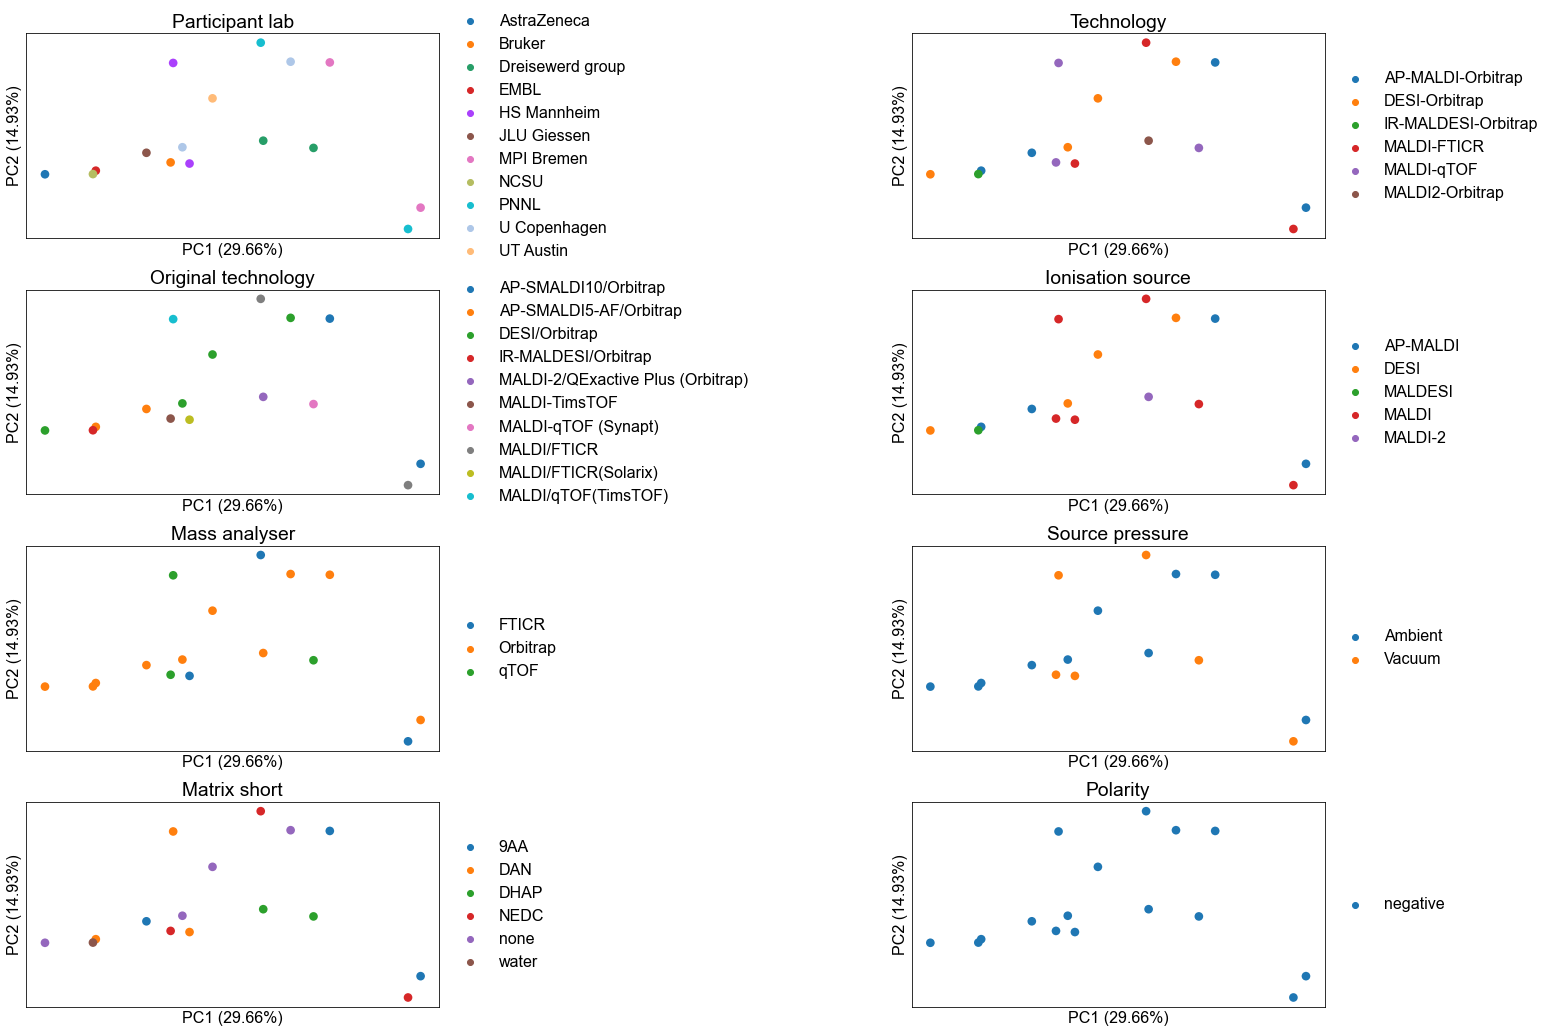

In [141]:
# Make plots
fname = "PCA_interlab_neg"

with rc_context():    
    ax = sc.pl.pca(adata, 
                   components=['1, 2'], 
                   color=[
#                     'Dataset name', 
                    'Participant lab', 
                    'Technology', 
                    'Original technology', 
                    'Ionisation source',
                    'Mass analyser', 
                    'Source pressure',
                    'Matrix short',
                    'Polarity', 
                   ],
                   size=300, 
                   ncols=2, # Number of columns to organise subplots in
                   legend_loc='right margin',
                   show=False, 
                   wspace=0.95,
                   annotate_var_explained = True
                  )
    plt.tight_layout()
#     plt.savefig(p_out/ f"{fname}.png")
plt.savefig(p_out / f"{fname}.pdf")

## Option 2: PCA based on the aggregated values also used in coarse class dot plot
- This is useful in case you want to see PCA loadings

In [13]:
# Load classification, add class size info

classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = get_class_size(classes[['name_short', 'main_coarse_class']].drop_duplicates(), 
                            'main_coarse_class')
chem_subclass = get_class_size(classes[['name_short', 'coarse_class', 'fine_class']],  # coarse class here is to sort rows in the plot
                              'fine_class')

In [21]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
                            polarity='positive', 
                            neutral_losses=['']
                           )

# Add property that you want to use for PCA
filtered_data['my_property'] = filtered_data['spot_intensity_tic_norm'] * 1 # this is just an example that does nothing to the column, but you can do whatever

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule(filtered_data, groupby_columns=np.append(metadata_columns, 'name_short').tolist())

# Map chemical classes
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

# Summarise data per class
class_data = summarise_per_class(mapped_data, groupby_columns=np.append(metadata_columns, 'main_coarse_class').tolist())

# Reshape
pca = class_data.pivot_table(values=['fraction_detected', 'my_property'],
                             index=metadata_columns, 
                             columns='main_coarse_class',
                             fill_value=0)

# Assemble adata
adata = assemble_adata(pca)

# Apply Z-score normalisation: If you use only detectability for PCA, this is not needed
sc.pp.scale(adata, zero_center=True) 

# Compute PCA
sc.tl.pca(adata, svd_solver='arpack')

C:\Users\ekelof\Anaconda3\envs\Spotting\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [22]:
pca.head()

fraction_detected  \
main_coarse_class                                                                                                                                                                                                                 Amines   
Dataset name                                       Participant lab  Technology        Original technology               Ionisation source Mass analyser Source pressure Matrix short Polarity Slide code Interlab All                      
AstraZeneca  DESI-Orbitrap  positive  70-400 m/... AstraZeneca      DESI-Orbitrap     DESI/Orbitrap                     DESI              Orbitrap      Ambient         none         positive 1A         True     True          0.916667   
Bruker  MALDI-qTOF  DHB  positive  Low m/z  13G    Bruker           MALDI-qTOF        MALDI-TimsTOF                     MALDI             qTOF          Vacuum          DHB          positive 13G        True     True          0.916667   
Dreisewerd group  MALDI-qTOF  DHAP  positive  F... Dreisewerd group MALDI-qTOF        MALDI-qTOF (Synapt)               MALDI             qTOF          Vacuum          DHAP         positive 2I         True     True          0.666667   
Dreisewerd group  MALDI2-Orbitrap  DHAP  positi... Dreisewerd group MALDI2-Orbitrap   MALDI-2/QExactive Plus (Orbitrap) MALDI-2           Orbitrap      Ambient         DHAP         positive 4F         True     True          0.916667   
EMBL  AP-MALDI-Orbitrap  DHB  positive  70-1510... EMBL             AP-MALDI-Orbitrap AP-SMALDI5-AF/Orbitrap            AP-MALDI          Orbitrap      Ambient         DHB          positive 7J         True     True          0.916667   

                                                                                                                                                                                                                                                             \
main_coarse_class                                                                                                                                                                                                      Amino acids, peptides, and analogues   
Dataset name                                       Participant lab  Technology        Original technology               Ionisation source Mass analyser Source pressure Matrix short Polarity Slide code Interlab All                                         
AstraZeneca  DESI-Orbitrap  positive  70-400 m/... AstraZeneca      DESI-Orbitrap     DESI/Orbitrap                     DESI              Orbitrap      Ambient         none         positive 1A         True     True                             0.744681   
Bruker  MALDI-qTOF  DHB  positive  Low m/z  13G    Bruker           MALDI-qTOF        MALDI-TimsTOF                     MALDI             qTOF          Vacuum          DHB          positive 13G        True     True                             0.914894   
Dreisewerd group  MALDI-qTOF  DHAP  positive  F... Dreisewerd group MALDI-qTOF        MALDI-qTOF (Synapt)               MALDI             qTOF          Vacuum          DHAP         positive 2I         True     True                             0.297872   
Dreisewerd group  MALDI2-Orbitrap  DHAP  positi... Dreisewerd group MALDI2-Orbitrap   MALDI-2/QExactive Plus (Orbitrap) MALDI-2           Orbitrap      Ambient         DHAP         positive 4F         True     True                             0.936170   
EMBL  AP-MALDI-Orbitrap  DHB  positive  70-1510... EMBL             AP-MALDI-Orbitrap AP-SMALDI5-AF/Orbitrap            AP-MALDI          Orbitrap      Ambient         DHB          positive 7J         True     True                             0.936170   

                                                                                                                                                                                                                                      \
main_coarse_class                                    

<ipython-input-121-a9ffd351601d>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


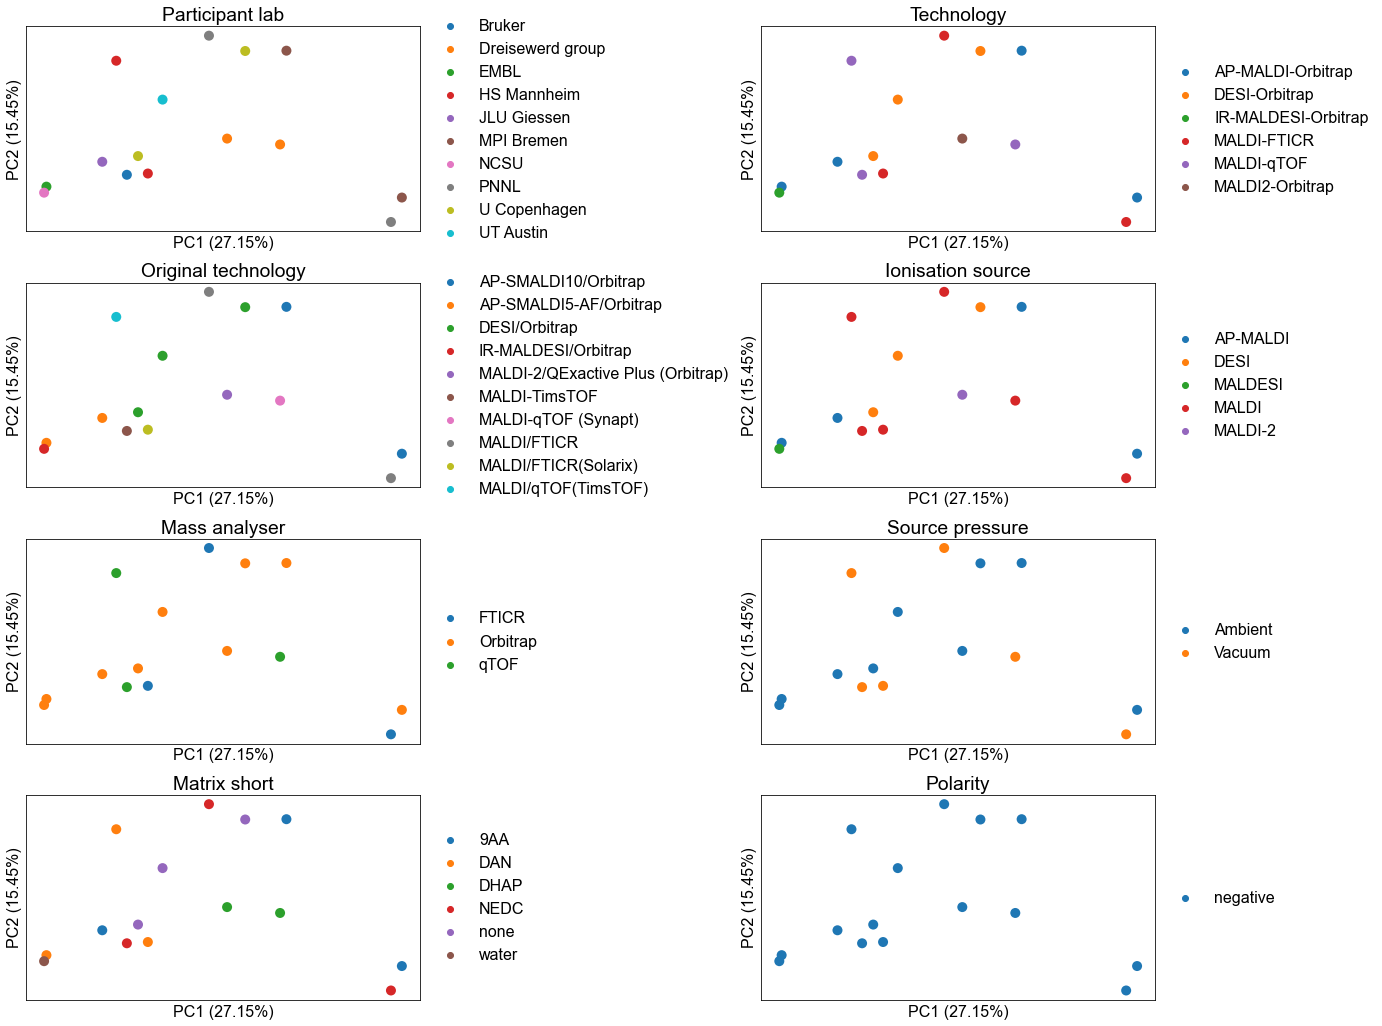

In [121]:
fname = "PCA_interlab_coarse_class_pos"

with rc_context():    
    ax = sc.pl.pca(adata, 
                   components=['1, 2'], 
                   color=[
#                     'Dataset name', 
                    'Participant lab', 
                    'Technology', 
                    'Original technology', 
                    'Ionisation source',
                    'Mass analyser', 
                    'Source pressure',
                    'Matrix short',
                    'Polarity', 
                   ],
                   size=400, 
                   ncols=2,
                   legend_loc='right margin',
                   show=False, 
                   wspace=0.7,
                   annotate_var_explained = True)
    plt.tight_layout()
#     plt.savefig(p_out/ f"{fname}.png")
#     plt.savefig(p_out / f"{fname}.pdf")

In [17]:
# # Extras

# # See how much PCA components explain variance
# sc.pl.pca_variance_ratio(adata)

# # Check loading plot
# sc.pl.pca_loadings(adata, components='1,2')

## Option 3: PCA based on the aggregated values also used in fine class dot plot
- All three opotions provide similar result, but this can be useful for the loading plot

In [18]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
                            polarity='negative', 
                            neutral_losses=['']
                           )

# Add property that you want to use for PCA
filtered_data['my_property'] = filtered_data['spot_intensity_tic_norm'] * 1 # this is just an example that does nothing to the column, but you can do whatever

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule(filtered_data, groupby_columns=np.append(metadata_columns, 'name_short').tolist())

# Map chemical classes
mapped_data = molecule_data.merge(chem_subclass, on='name_short', how='left')

# Summarise data per class
class_data = summarise_per_class(mapped_data, groupby_columns=np.append(metadata_columns, 'fine_class').tolist())

# Reshape
pca = class_data.pivot_table(values=['fraction_detected', 'my_property'],
                             index=metadata_columns, 
                             columns='fine_class',
                             fill_value=0)

# Assemble adata
adata = assemble_adata(pca)

# Apply Z-score normalisation: If you use only detectability for PCA, this is not needed
sc.pp.scale(adata, zero_center=True) 

# Compute PCA
sc.tl.pca(adata, svd_solver='arpack')

C:\Users\ekelof\Anaconda3\envs\Spotting\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
pca.head()

fraction_detected  \
fine_class                                                                                                                                                                                                             Acidic amino acids   
Dataset name                                       Participant lab  Technology        Original technology               Ionisation source Mass analyser Source pressure Matrix short Polarity Slide code Interlab All                       
AstraZeneca  DESI-Orbitrap  negative  70-400 m/... AstraZeneca      DESI-Orbitrap     DESI/Orbitrap                     DESI              Orbitrap      Ambient         none         negative 1C         True     True              0.875   
Bruker  MALDI-qTOF  NEDC  negative  Low m/z  13J   Bruker           MALDI-qTOF        MALDI-TimsTOF                     MALDI             qTOF          Vacuum          NEDC         negative 13J        True     True              0.750   
Dreisewerd group  MALDI-qTOF  DHAP  negative  F... Dreisewerd group MALDI-qTOF        MALDI-qTOF (Synapt)               MALDI             qTOF          Vacuum          DHAP         negative 7B         True     True              0.250   
Dreisewerd group  MALDI2-Orbitrap  DHAP  negati... Dreisewerd group MALDI2-Orbitrap   MALDI-2/QExactive Plus (Orbitrap) MALDI-2           Orbitrap      Ambient         DHAP         negative 3A         True     True              0.250   
EMBL  AP-MALDI-Orbitrap  DAN  negative  70-1510... EMBL             AP-MALDI-Orbitrap AP-SMALDI5-AF/Orbitrap            AP-MALDI          Orbitrap      Ambient         DAN          negative 7A         True     True              0.625   

                                                                                                                                                                                                                                                          \
fine_class                                                                                                                                                                                                             Arginine derivatives (guanidines)   
Dataset name                                       Participant lab  Technology        Original technology               Ionisation source Mass analyser Source pressure Matrix short Polarity Slide code Interlab All                                      
AstraZeneca  DESI-Orbitrap  negative  70-400 m/... AstraZeneca      DESI-Orbitrap     DESI/Orbitrap                     DESI              Orbitrap      Ambient         none         negative 1C         True     True                               1.0   
Bruker  MALDI-qTOF  NEDC  negative  Low m/z  13J   Bruker           MALDI-qTOF        MALDI-TimsTOF                     MALDI             qTOF          Vacuum          NEDC         negative 13J        True     True                               0.8   
Dreisewerd group  MALDI-qTOF  DHAP  negative  F... Dreisewerd group MALDI-qTOF        MALDI-qTOF (Synapt)               MALDI             qTOF          Vacuum          DHAP         negative 7B         True     True                               0.2   
Dreisewerd group  MALDI2-Orbitrap  DHAP  negati... Dreisewerd group MALDI2-Orbitrap   MALDI-2/QExactive Plus (Orbitrap) MALDI-2           Orbitrap      Ambient         DHAP         negative 3A         True     True                               0.2   
EMBL  AP-MALDI-Orbitrap  DAN  negative  70-1510... EMBL             AP-MALDI-Orbitrap AP-SMALDI5-AF/Orbitrap            AP-MALDI          Orbitrap      Ambient         DAN          negative 7A         True     True                               0.4   

                                                                                                                                                                                                                                       \
fine_class                                                           

... storing 0 as categorical
... storing 'fine_class' as categorical
<ipython-input-20-401b87ebb163>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


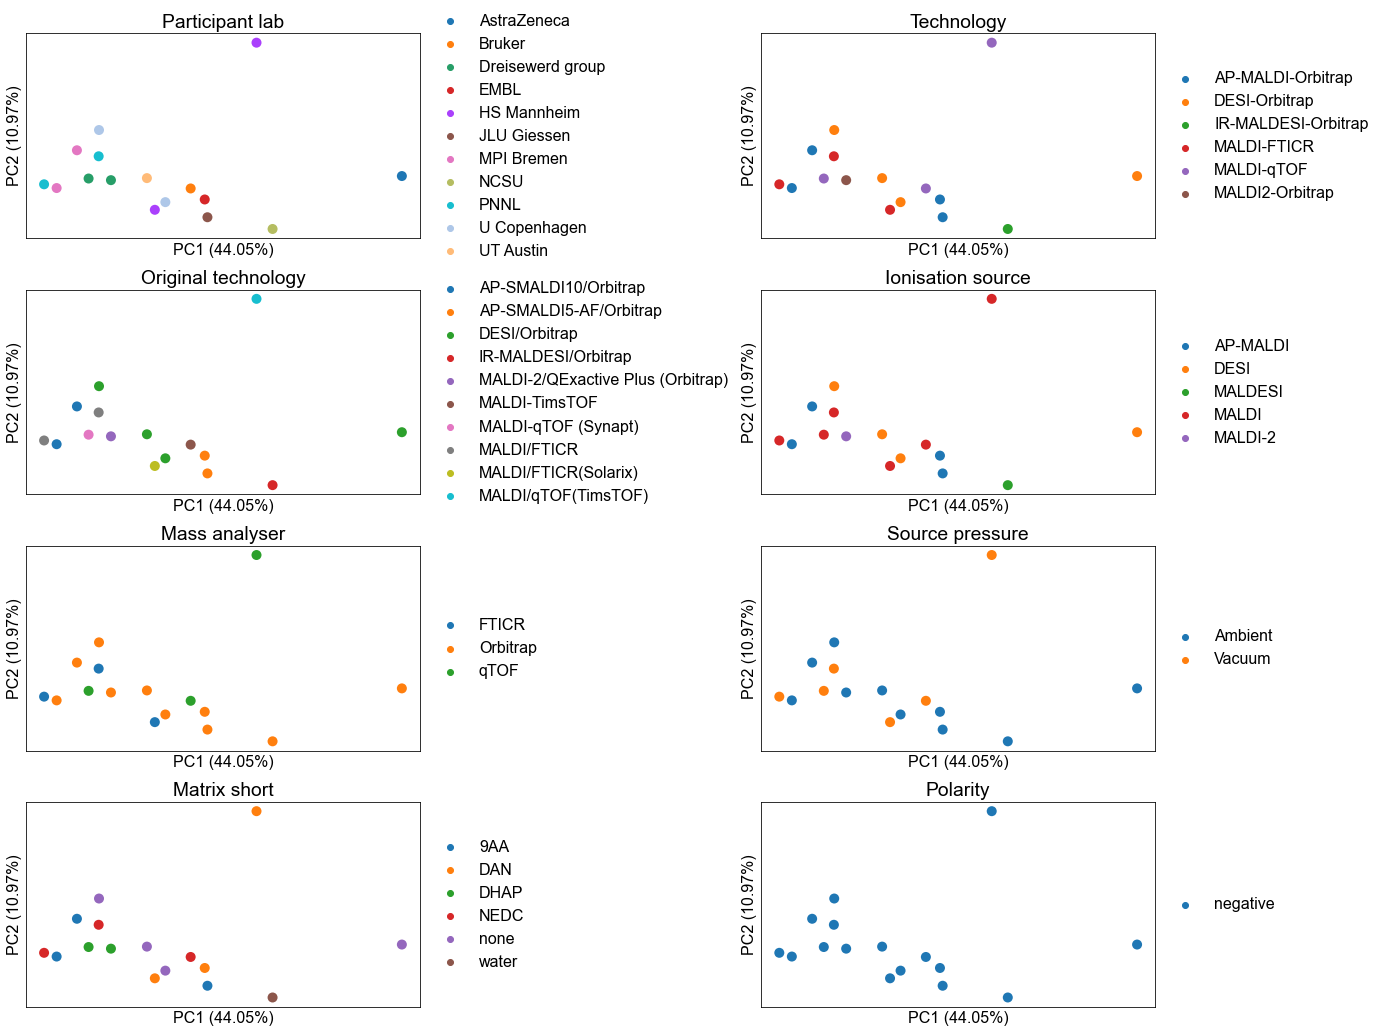

In [20]:
fname = "PCA_interlab_fine_class_neg"

with rc_context():    
    ax = sc.pl.pca(adata, 
                   components=['1,2'], 
                   color=[
#                     'Dataset name', 
                    'Participant lab', 
                    'Technology', 
                    'Original technology', 
                    'Ionisation source',
                    'Mass analyser', 
                    'Source pressure',
                    'Matrix short',
                    'Polarity', 
                   ],
                   size=400, 
                   ncols=2,
                   legend_loc='right margin',
                   show=False, 
                   wspace=0.7,
                   annotate_var_explained = True)
    plt.tight_layout()
#     plt.savefig(p_out/ f"{fname}.png")
#     plt.savefig(p_out / f"{fname}.pdf")